In [1]:
import os
import json
import math
import zarr
import torch
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from data_util_prev import Downloader, DATASET_TREE
from torch.utils.data import IterableDataset, DataLoader

/home/jw/anaconda3/envs/qc/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
data_dir = os.path.join("..", "climatehackai-2023")

start_year, start_month = 2021, 1
end_year, end_month = 2021, 11

downloader = Downloader(data_dir=data_dir)
downloader.download(start_year, end_year, start_month, end_month)

# Load data into a dictionary
# data_dict = downloader.load_dataset(start_year, start_month, end_year, end_month)

In [3]:
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

In [4]:
site_locations.keys()

dict_keys(['hrv', 'nonhrv', 'weather', 'aerosols'])

In [5]:
hrv_sites = list(site_locations["hrv"])
print(len(hrv_sites))

nonhrv_sites = list(site_locations["nonhrv"])
print(len(nonhrv_sites))

weather_sites = list(site_locations["weather"])
print(len(weather_sites))

print(len(set(hrv_sites).union(set(nonhrv_sites)).union(set(weather_sites))))

993
993
993
993


In [6]:
hrv_paths = [os.path.join(data_dir, "satellite-hrv", "2021", f)
             for f in DATASET_TREE["satellite-hrv"][2021][:-1]]
hrv_paths

['../climatehackai-2023/satellite-hrv/2021/1.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/2.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/3.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/4.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/5.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/6.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/7.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/8.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/9.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/10.zarr.zip',
 '../climatehackai-2023/satellite-hrv/2021/11.zarr.zip']

In [7]:
hrv_data = zarr.open(hrv_paths[0], mode='r')

In [8]:
hrv_data.time.astype("datetime64[ns]")[:]

array(['2021-01-01T04:00:00.000000000', '2021-01-01T04:05:00.000000000',
       '2021-01-01T04:10:00.000000000', ...,
       '2021-01-31T21:50:00.000000000', '2021-01-31T21:55:00.000000000',
       '2021-01-31T22:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
def load_parquet(file_path):
    return pd.read_parquet(file_path, engine='pyarrow').drop("generation_wh", axis=1)

In [10]:
pv_paths = [os.path.join(data_dir, "pv", "2021", f) for f in DATASET_TREE["pv"][2021][:-1]]
pv_paths

['../climatehackai-2023/pv/2021/1.parquet',
 '../climatehackai-2023/pv/2021/2.parquet',
 '../climatehackai-2023/pv/2021/3.parquet',
 '../climatehackai-2023/pv/2021/4.parquet',
 '../climatehackai-2023/pv/2021/5.parquet',
 '../climatehackai-2023/pv/2021/6.parquet',
 '../climatehackai-2023/pv/2021/7.parquet',
 '../climatehackai-2023/pv/2021/8.parquet',
 '../climatehackai-2023/pv/2021/9.parquet',
 '../climatehackai-2023/pv/2021/10.parquet',
 '../climatehackai-2023/pv/2021/11.parquet']

In [11]:
pv_dfs = [load_parquet(pv_path) for pv_path in pv_paths]

In [12]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov"]
pv_lens = [len(df.index.get_level_values(level=1).unique()) for df in pv_dfs]

(800.0, 900.0)

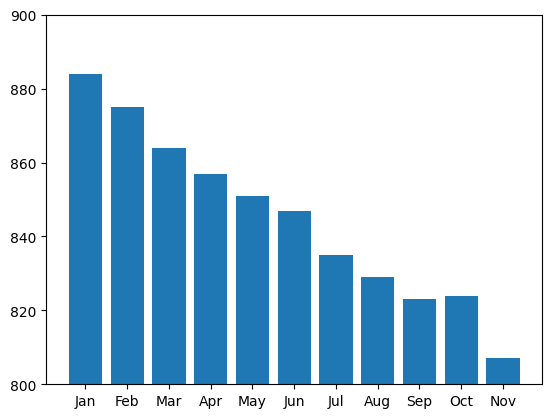

In [13]:
plt.bar(months, pv_lens)
plt.ylim(800, 900)

In [64]:
pv_meta = pd.read_csv(os.path.join(data_dir, "pv", "metadata.csv"), index_col="ss_id")
pv_meta

,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
ss_id,,,,,,,
2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
...,...,...,...,...,...,...,...
27063,51.41,-2.49,E01014398,185.0,35.0,4.00,2018-04-18
27064,51.47,-0.59,E01016588,180.0,45.0,2.00,2018-04-18
27065,51.36,-2.93,E01014817,125.0,37.0,4.00,2018-04-18


In [73]:
pv_meta_filtered = pv_meta[pv_meta.index.isin(set(hrv_sites))]
pv_meta_filtered

,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
ss_id,,,,,,,
2607,52.44,-0.12,E01018211,200.0,35.0,2.94,2011-08-25
2626,54.99,-3.18,S00097762,270.0,22.0,3.60,2011-08-18
2631,51.81,-2.50,E01022250,130.0,30.0,4.00,2011-08-27
2657,51.49,0.36,E01015937,185.0,47.0,4.00,2011-08-26
2660,52.22,1.49,E01030209,90.0,36.0,4.00,2011-08-29
...,...,...,...,...,...,...,...
27063,51.41,-2.49,E01014398,185.0,35.0,4.00,2018-04-18
27064,51.47,-0.59,E01016588,180.0,45.0,2.00,2018-04-18
27065,51.36,-2.93,E01014817,125.0,37.0,4.00,2018-04-18


In [39]:
class Dataset(IterableDataset):
    def __init__(self, hrv_paths, nonhrv_paths, pv_paths, weather_paths, 
                 site_locations, weather_features, sites=None):
        super(Dataset, self).__init__()
        # Site Locations
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())
        
        self.hrv_paths = hrv_paths
        self.nonhrv_paths = nonhrv_paths
        self.pv_paths = pv_paths
        self.weather_paths = weather_paths
        self.weather_features = weather_features
        self.load()
        
        self.OFFSET_1_HR = 12
        
    def load(self):
        # HRV
        self.hrvs = [zarr.open(hrv_path, mode='r') for hrv_path in self.hrv_paths]
        self.time_index = [hrv.time.astype('datetime64[ns]') for hrv in self.hrvs]
        
        # Dataset Configuration
        self.time_mapping = np.cumsum([len(hrv.time) for hrv in self.hrvs])
        self.start = 0
        self.end = self.time_mapping[-1]
        self.length = self.end
        
        # PV
        self.pvs = [self._load_parquet(pv_path) for pv_path in self.pv_paths]
        
        # Non-HRV
        self.nonhrvs = [zarr.open(nonhrv_paths, mode='r') for nonhrv_paths in self.nonhrv_paths]
        
        # Weather
        self.weathers = [self._load_zarr(weather_path) for weather_path in self.weather_paths]
        
    def _load_parquet(self, file_path):
        return pd.read_parquet(file_path, engine='pyarrow').drop("generation_wh", axis=1)
    
    def _load_zarr(self, file_path):
        return xr.open_dataset(file_path, engine="zarr", consolidated=True,)
        
    def _get_split(self, i):
        s = np.argmax((i - self.time_mapping) < 0)
        return s, i - self.time_mapping[s]
        
    def __iter__(self):
        for i in range(self.start, self.end):
            split, offset = self._get_split(i)
            if offset + self.OFFSET_1_HR >= 0:
                continue
            cur_ts = pd.Timestamp(train_dataset.time_index[split][offset], tz="UTC")
            hrv_data = self.hrvs[split].data[offset:offset+self.OFFSET_1_HR]
            nonhrv_data = self.nonhrvs[split].data[offset:offset+self.OFFSET_1_HR]
            
            cur_ts_no_tz = pd.Timestamp(train_dataset.time_index[split][offset])
            six_hours = slice(cur_ts_no_tz - np.timedelta64(1, 'h'), cur_ts_no_tz + np.timedelta64(5, 'h'))
            weather_data = self.weathers[split].sel(time=six_hours)
            weather_data_arr = [weather_data[col].to_numpy() for col in self.weather_features]
            
            pv = self.pvs[split]
            pv_features = pv.xs(slice(cur_ts, cur_ts + np.timedelta64(55, 'm')), drop_level=False)
            pv_targets = pv.xs(
                slice(
                    str(cur_ts + np.timedelta64(1, 'h')),
                    str(cur_ts + np.timedelta64(4, 'h') + np.timedelta64(55, 'm')),
                ),
                drop_level=False,
            )

            for site in self._sites:
                
                try:
                
                    # PV features and targets
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)

                    # HRV
                    x, y = self._site_locations["hrv"][site]
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)
                    
                    # Non HRV
                    x, y = self._site_locations["nonhrv"][site]
                    nonhrv_features = nonhrv_data[:, y - 64 : y + 64, x - 64 : x + 64, :]
                    assert nonhrv_features.shape == (12, 128, 128, 11)
                    
                    # Weather
                    x, y = self._site_locations["weather"][site]
                    weather_features = np.array([weather_data[:, y - 64 : y + 64, x - 64 : x + 64] for weather_data in weather_data_arr])
                    assert weather_features.shape == (len(self.weather_features), 6, 128, 128)

                    yield site_features, hrv_features, nonhrv_features, weather_features, site_targets
                
                except Exception as e:
                    # print(e)
                    continue
            
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset  # the dataset copy in this worker process
    # Critical! Open data file again in the sub-processes
    dataset.load()
    # configure the dataset to only process the split workload
    per_worker = int(
        math.ceil(
            (dataset.length) / float(worker_info.num_workers)
        )
    )
    worker_id = worker_info.id
    dataset.start = dataset.start + worker_id * per_worker
    dataset.end = min(dataset.start + per_worker, dataset.end)

In [5]:
BATCH_SIZE = 2048

with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

hrv_paths = [os.path.join(data_dir, "satellite-hrv", "2021", "10.zarr.zip"),
             os.path.join(data_dir, "satellite-hrv", "2021", "11.zarr.zip")]

nonhrv_paths = [os.path.join(data_dir, "satellite-nonhrv", "2021", "10.zarr.zip"),
                os.path.join(data_dir, "satellite-nonhrv", "2021", "11.zarr.zip")]

pv_paths = [os.path.join(data_dir, "pv", "2021", "10.parquet"),
            os.path.join(data_dir, "pv", "2021", "11.parquet")]

weather_paths = [os.path.join(data_dir, "weather", "2021", "10.zarr.zip"),
                 os.path.join(data_dir, "weather", "2021", "11.zarr.zip")]

train_dataset = Dataset(hrv_paths=hrv_paths, 
                        nonhrv_paths=nonhrv_paths,
                        pv_paths=pv_paths,
                        weather_paths=weather_paths,
                        site_locations=site_locations,
                        weather_features=["alb_rad", "aswdifd_s"])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0, worker_init_fn=worker_init_fn)

In [6]:
train_dataset.length * len(site_locations["hrv"]) / 2048

4132.974609375

In [7]:
for site_features, hrv_features, nonhrv_features, weather_features, site_targets in train_dataloader:
    print(site_features.shape)
    print(hrv_features.shape)
    print(nonhrv_features.shape)
    print(weather_features.shape)
    print(site_targets.shape)
    break

torch.Size([2048, 12])
torch.Size([2048, 12, 128, 128])
torch.Size([2048, 12, 128, 128, 11])
torch.Size([2048, 2, 6, 128, 128])
torch.Size([2048, 48])


In [100]:
hrvs = [zarr.open(hrv_paths[i], mode='r') for i in range(len(hrv_paths))]
ls = np.cumsum([len(hrv.time) for hrv in hrvs])
ls

array([ 6725, 13232])

In [40]:
def get_split(i, ls):
    s = np.argmax((i - ls) < 0)
    return s, i - ls[s]

In [41]:
get_split(6725, ls)

(1, -6507)

In [35]:
df = train_dataset.pvs[0]
df.xs(slice(, 
            pd.Timestamp(train_dataset.time_index[0][0], tz="UTC") + np.timedelta64(55, 'm')), drop_level=False)

power
timestamp                 ss_id       
2020-03-01 04:00:00+00:00 2607     0.0
                          2631     0.0
                          2657     0.0
                          2660     0.0
                          2729     0.0
...                                ...
2020-03-01 04:55:00+00:00 27061    0.0
                          27063    0.0
                          27064    0.0
                          27065    0.0
                          27066    0.0

[10955 rows x 1 columns]

In [30]:
df.index[0]

(Timestamp('2020-03-01 00:00:00+0000', tz='UTC'), 2607)

In [83]:
train_dataset.weathers[0].time

<xarray.DataArray 'time' (time: 589)>
array(['2020-03-01T04:00:00.000000000', '2020-03-01T05:00:00.000000000',
       '2020-03-01T06:00:00.000000000', ..., '2020-03-31T20:00:00.000000000',
       '2020-03-31T21:00:00.000000000', '2020-03-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01T04:00:00 ... 2020-03-31T22:00:00

In [87]:
six_hours = slice(str(pd.Timestamp(train_dataset.time_index[0][0]) - np.timedelta64(1, 'h')), 
                  str(pd.Timestamp(train_dataset.time_index[0][0]) + np.timedelta64(5, 'h')))
train_dataset.weathers[0]["alb_rad"].sel(time=six_hours).to_numpy().shape

(6, 305, 289)

In [129]:
train_dataset.nonhrvs[0].data[:12, :, :, :].shape

(12, 293, 333, 11)

In [124]:
list(train_dataset.nonhrvs[0].channel[:])

['IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

In [126]:
list(train_dataset.nonhrvs[0].channel[:]).index("VIS008")

8

In [13]:
hrv_features.unsqueeze(2).shape, nonhrv_features.shape

(torch.Size([128, 12, 1, 128, 128]), torch.Size([128, 12, 128, 128, 11]))

In [15]:
torch.cat((hrv_features.unsqueeze(2), nonhrv_features.permute(0, 1, 4, 2, 3)), dim=2).shape

torch.Size([128, 12, 12, 128, 128])

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from data_util import Dataset

data_dir = os.path.join("..", "climatehackai-2023")

weather_features_name = ["alb_rad", "aswdifd_s", "aswdir_s", #"cape_con", 
                 "clch", "clcl", "clcm", "clct", "h_snow",
                 "relhum_2m", "t_2m", "tot_prec"]

with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

hrv_paths = [os.path.join(data_dir, "satellite-hrv", "2021", f"{i}.zarr.zip") for i in range(9, 11)]

nonhrv_paths = [os.path.join(data_dir, "satellite-nonhrv", "2021", f"{i}.zarr.zip") for i in range(9, 11)]

pv_paths = [os.path.join(data_dir, "pv", "2021", f"{i}.parquet") for i in range(9, 11)]

weather_paths = [os.path.join(data_dir, "weather", "2021", f"{i}.zarr.zip") for i in range(9, 11)]

num_sites = 10

train_dataset = Dataset(hrv_paths=hrv_paths, 
                     nonhrv_paths=nonhrv_paths,
                     pv_paths=pv_paths,
                     weather_paths=weather_paths,
                     site_locations=site_locations,
                     weather_features=weather_features_name,
                     num_sites=num_sites,
                     length=10,
                     site_shuffle=True)

In [26]:
for i, data in enumerate(train_dataset):
    pv_features, hrv_features, non_hrv_features, weather_features, pv_targets, ts = data
    if i == np.random.randint(100):
        break
print(ts)
print(pv_features.shape, hrv_features.shape, non_hrv_features.shape, weather_features.shape, pv_targets.shape)

2021-09-12 16:20:00+00:00
(12,) (12, 128, 128) (12, 128, 128, 11) (11, 6, 128, 128) (48,)


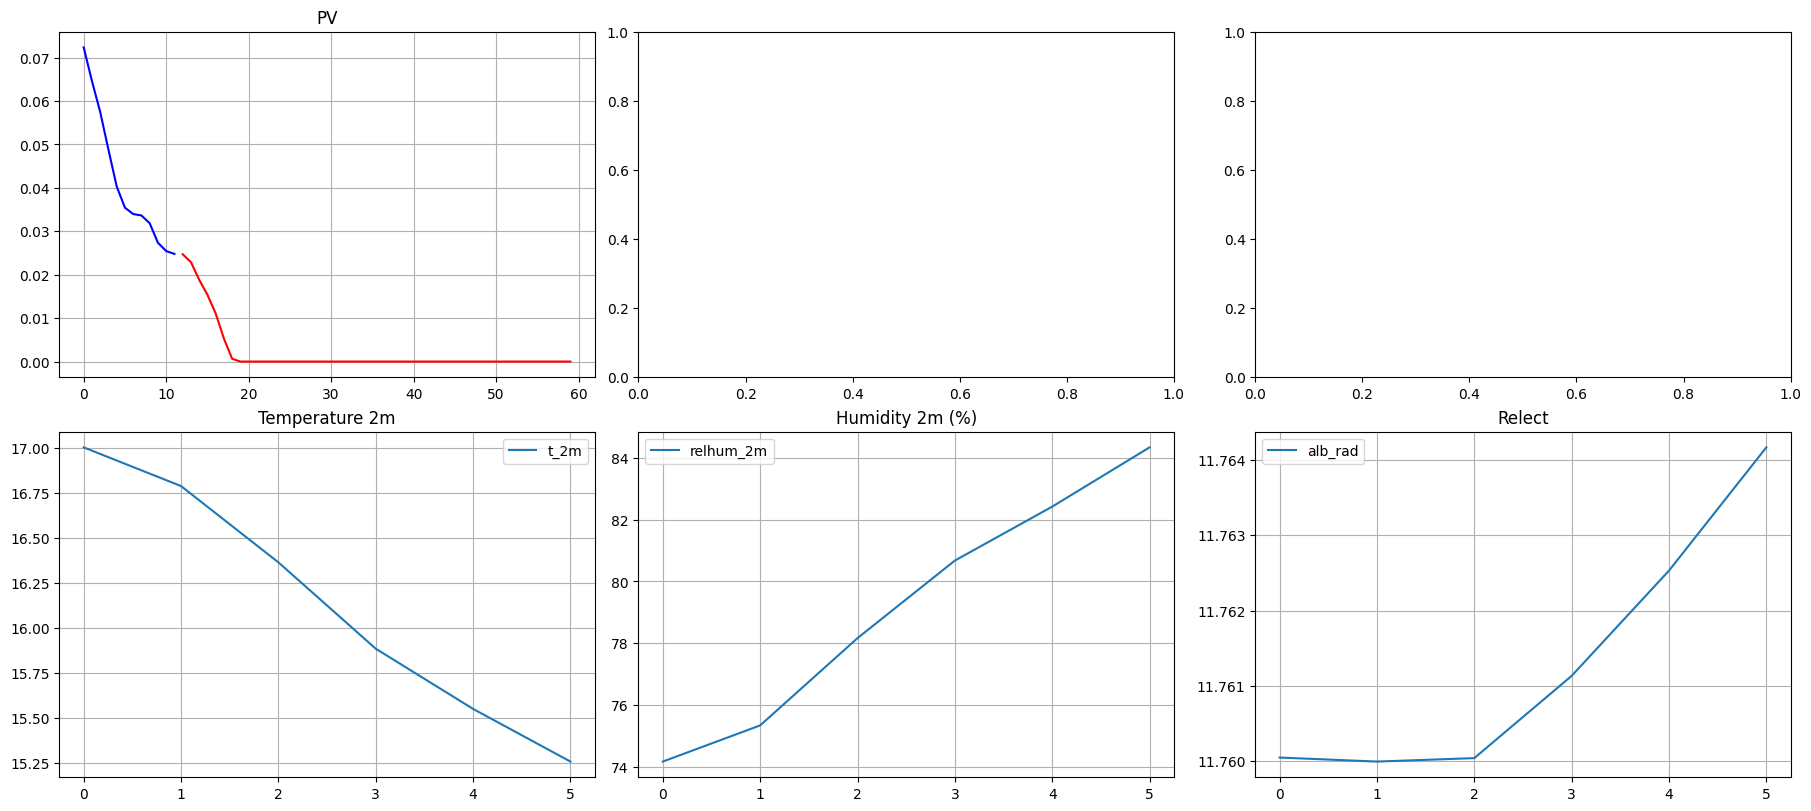

In [27]:
fig, axs = plt.subplots(2, 3, layout='constrained', figsize=(18, 8))
axs[0, 0].plot(np.arange(pv_features.shape[0]), pv_features, 'b')
axs[0, 0].plot(np.arange(pv_features.shape[0], pv_features.shape[0] + pv_targets.shape[0]), pv_targets, 'r')
axs[0, 0].grid()
axs[0, 0].set_title("PV")
# axs[1].plot(hrv_features.reshape(12, 128*128).mean(axis=-1), label="hrv")
wfi = 9
axs[1, 0].plot(weather_features[wfi].reshape(6, 128*128).mean(axis=-1) - 273, label=weather_features_name[wfi])
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 0].set_title("Temperature 2m")
wfi = 8
axs[1, 1].plot(weather_features[wfi].reshape(6, 128*128).mean(axis=-1), label=weather_features_name[wfi])
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].set_title("Humidity 2m (%)")
wfi = 0
axs[1, 2].plot(weather_features[wfi].reshape(6, 128*128).mean(axis=-1), label=weather_features_name[wfi])
axs[1, 2].legend()
axs[1, 2].grid()
axs[1, 2].set_title("Relect")
plt.show()

In [127]:
import xarray as xr

def _load_zarr(file_path):
    return xr.open_dataset(file_path, engine="zarr", consolidated=True,)

def _load_parquet(file_path):
    return pd.read_parquet(file_path, engine='pyarrow').drop("generation_wh", axis=1)

In [128]:
weather_paths = [os.path.join(data_dir, "weather", "2021", f"{i}.zarr.zip") for i in range(9, 10)]
weathers = [_load_zarr(weather_path) for weather_path in weather_paths]

pv_paths = [os.path.join(data_dir, "pv", "2021", f"{i}.parquet") for i in range(9, 11)]
pvs = [_load_parquet(pv_path) for pv_path in pv_paths]
pv_data = pvs[0].xs(site, level=1)

cur_ts = pd.Timestamp("2021-09-01 00:06:00", tz="UTC")

In [208]:
weather_paths = [os.path.join(data_dir, "weather", "2021", f"{i}.zarr.zip") for i in range(1, 10)]
weathers = [_load_zarr(weather_path) for weather_path in weather_paths]

In [226]:
all_d = np.concatenate([w.t_2m.to_numpy() for w in weathers], axis=0)
all_d.shape

(4984, 305, 289)

In [239]:
all_d.mean()

283.74854

In [240]:
all_d.std()

5.5142407

In [227]:
all_d_mean, all_d_std = all_d.mean(axis=0), all_d.std(axis=0)

In [228]:
all_d_mean.shape, all_d_std.shape

((305, 289), (305, 289))

In [231]:
with open('t_2m_2021_mean.npy', 'wb') as f:
    np.save(f, all_d_mean)
    
with open('t_2m_2021_std.npy', 'wb') as f:
    np.save(f, all_d_std)

In [233]:
with open('t_2m_2021_mean.npy', 'rb') as f:
    a = np.load(f)

In [235]:
a.shape

(305, 289)

In [176]:
site = np.random.choice(list(site_locations["weather"].keys()))
x, y = site_locations["weather"][site]

alb_rad = weathers[0].alb_rad.to_numpy()
site_alb_rad = alb_rad[:, y - 64 : y + 64, x - 64 : x + 64]
site_alb_rad = site_alb_rad.reshape(site_alb_rad.shape[0], 128*128).mean(axis=-1).reshape(int(site_alb_rad.shape[0] / 19), 19)
site_alb_rad_normed = (site_alb_rad - site_alb_rad.min()) / (site_alb_rad.max() - site_alb_rad.min())

t_2m = weathers[0].t_2m.to_numpy()
site_t_2m = t_2m[:, y - 64 : y + 64, x - 64 : x + 64]
site_t_2m = site_t_2m.reshape(site_t_2m.shape[0], 128*128).mean(axis=-1).reshape(int(site_t_2m.shape[0] / 19), 19)
site_t_2m_normed = (site_t_2m - site_t_2m.min()) / (site_t_2m.max() - site_t_2m.min())

relhum_2m = weathers[0].relhum_2m.to_numpy()
site_relhum_2m = relhum_2m[:, y - 64 : y + 64, x - 64 : x + 64]
site_relhum_2m = site_relhum_2m.reshape(site_relhum_2m.shape[0], 128*128).mean(axis=-1).reshape(int(site_relhum_2m.shape[0] / 19), 19)
site_relhum_2m_normed = (site_relhum_2m - site_relhum_2m.min()) / (site_relhum_2m.max() - site_relhum_2m.min())

clct = weathers[0].clct.to_numpy()
site_clct = clct[:, y - 64 : y + 64, x - 64 : x + 64]
site_clct = site_clct.reshape(site_clct.shape[0], 128*128).mean(axis=-1).reshape(int(site_clct.shape[0] / 19), 19)
site_clct_normed = (site_clct - site_clct.min()) / (site_clct.max() - site_clct.min())

site, x, y

(10841, 127, 131)

In [105]:
site_alb_rad.shape

(30, 19)

In [186]:
ind = 0
_pv_data = pv_data[(pv_data.index >= "2021-09-01 04:00:00") & (pv_data.index <= "2021-09-01 22:00:00")].values.flatten()[::12]

In [187]:
_pv_data

array([0.        , 0.        , 0.0096169 , 0.13861233, 0.34964511,
       0.53033985, 0.6558797 , 0.72618045, 0.75494135, 0.73302256,
       0.66373534, 0.55362707, 0.39869774, 0.20499068, 0.04162045,
       0.        , 0.        , 0.        , 0.        ])

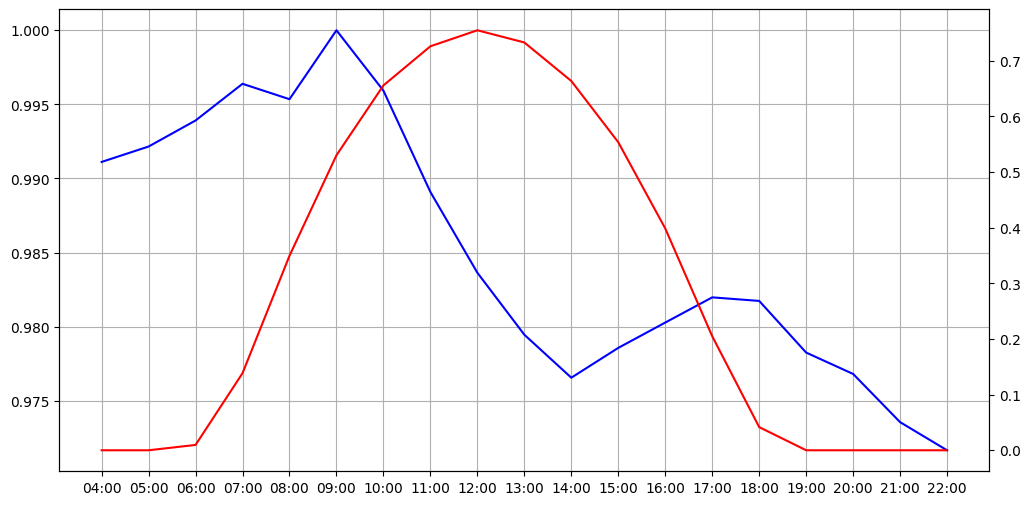

In [188]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], site_alb_rad_normed[ind], "b", label="alb_rad")
ax2.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], _pv_data, "r", label="pv")
ax1.grid()

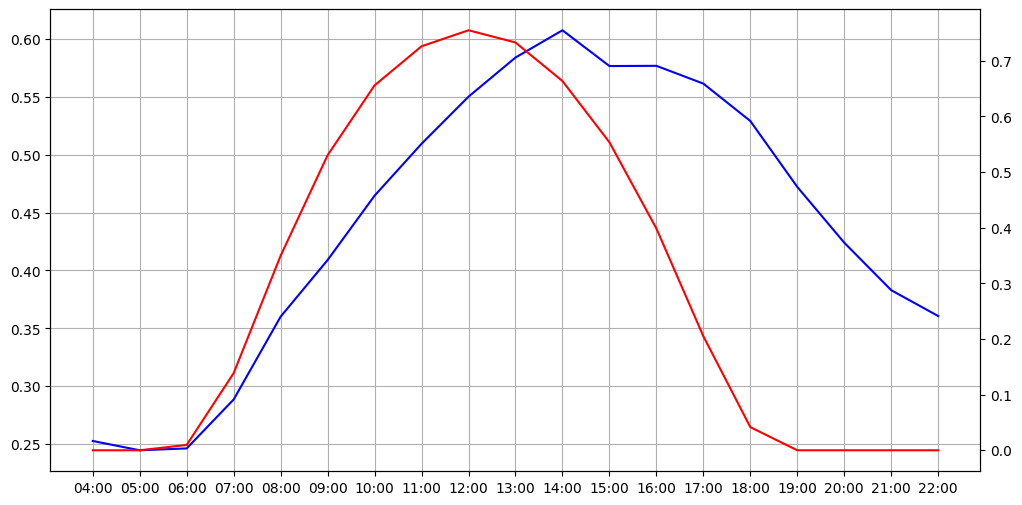

In [200]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], site_t_2m_normed[ind], "b", label="t_2m")
ax2.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], _pv_data, "r", label="pv")
ax1.grid()

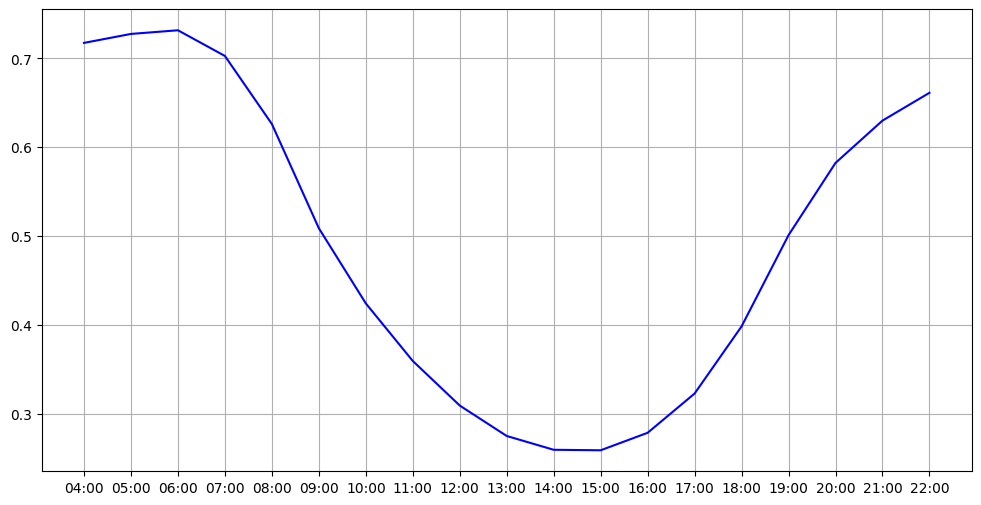

In [197]:
fig, ax1 = plt.subplots(figsize=(12,6))
# ax2 = ax1.twinx()
ax1.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], site_relhum_2m_normed[ind], "b", label="relhum_2m")
ax2.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], _pv_data, "r", label="pv")
ax1.grid()

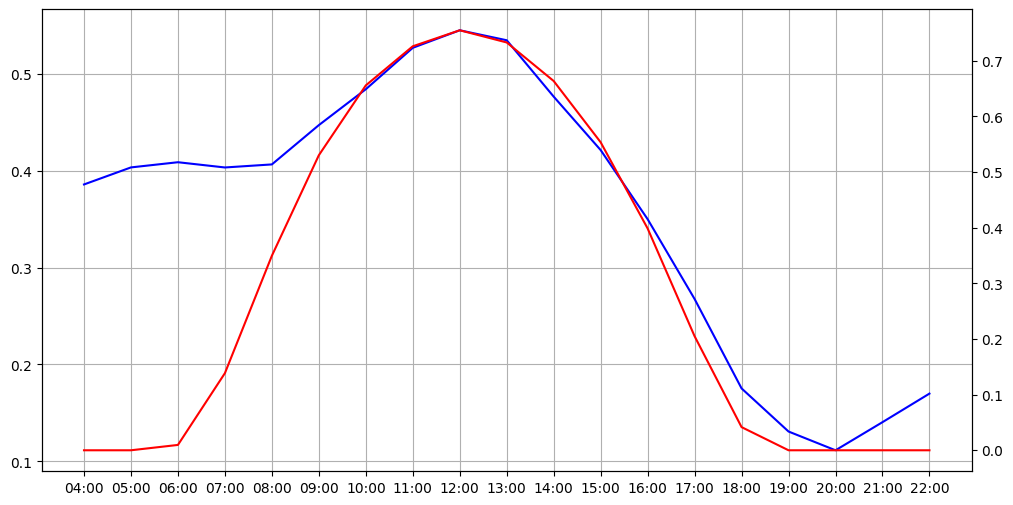

In [194]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], site_clct_normed[ind], "b", label="clct")
ax2.plot([str(s)[:-3] for s in pd.date_range(start='04:00:00', end='22:00:00', periods=19).time], _pv_data, "r", label="pv")
ax1.grid()